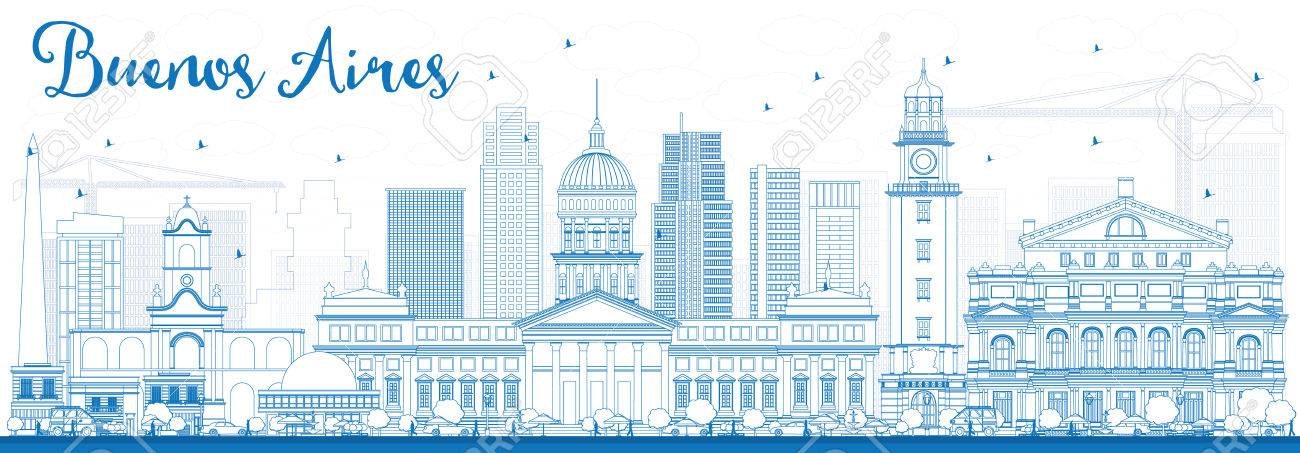

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import re 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import warnings 
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)

plt.style.use('seaborn')

In [2]:
data = pd.read_csv('depos.csv')
data.head(2)

,Unnamed: 0,rooms,age,district,bathrooms,information,parking_lots,bedrooms,expenses,name,price,covered_square,total_square,toilets
0,0,2,Frente,Belgrano,0,"\n\t\t\n\t\t\n\t\t,Cantidad dormitorios: ,2,\n...",2,1,$ 7.000,Departamento · 102m² · 3 Ambientes,298000.0,3,102,3
1,1,4,Frente,Caballito,4,"\n\t\t\n\t\t\n\t\t,Cantidad pisos en edificio:...",1,3,$ 9.900,Departamento · 141m² · 4 Ambientes · 1 Cochera,490000.0,141m²,154,9


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16634 entries, 0 to 16633
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      16634 non-null  int64  
 1   rooms           16630 non-null  object 
 2   age             13590 non-null  object 
 3   district        16634 non-null  object 
 4   bathrooms       16622 non-null  object 
 5   information     16355 non-null  object 
 6   parking_lots    16553 non-null  object 
 7   bedrooms        16067 non-null  object 
 8   expenses        10024 non-null  object 
 9   name            16634 non-null  object 
 10  price           16634 non-null  float64
 11  covered_square  16634 non-null  object 
 12  total_square    16634 non-null  int64  
 13  toilets         14787 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.8+ MB


In [4]:
data.drop('Unnamed: 0', axis=1, inplace=True) # drop Unnamed column

print(data.isna().sum())# NaN values

rooms                4
age               3044
district             0
bathrooms           12
information        279
parking_lots        81
bedrooms           567
expenses          6610
name                 0
price                0
covered_square       0
total_square         0
toilets           1847
dtype: int64


### Extracting some values from "name" and "information" columns. Feature engineering.

In [5]:
def info_extracter(line):
    "Auxiliary function for extracting some text values from information columns"
    # Removes tabs, spaces and extra commas
    line = line.replace('\t','').replace('\n','').replace(',',' ').strip()
    
    # Extracts useful info
    regex =  r"Cantidad dormitorios:  \d|Cantidad pisos en edificio:  \d|Departamentos por piso:  \d|Pileta|Gimnasio|SUM|Vigilancia"
    line = re.findall(regex, line)
    
    return str(line)

In [6]:
data.information = data.information.astype('str')
data.name = data.name.astype('str')

data.information = data.information.map(lambda x: info_extracter(x))
data.sample(2)

,rooms,age,district,bathrooms,information,parking_lots,bedrooms,expenses,name,price,covered_square,total_square,toilets
5453,3,A estrenar,Nuñez,2,['Cantidad dormitorios: 2'],1,2,NaN,Departamento · 94m² · 3 Ambientes · 1 Cochera,360000.0,94m²,109,1
7350,4,17,Puerto Madero,2,"['Cantidad pisos en edificio: 9', 'Cantidad d...",1,3,NaN,Departamento · 132m² · 4 Ambientes · 1 Cochera,630000.0,132m²,144,1


In [7]:
# extracting some numbers from information and name columns and creating a new columns
data['parking_lots_2'] = data.name.str.extract(r'(\d+)\s*Cochera?\b')
data['bedrooms_2'] = data.information.str.extract(r'dormitorios\W\s+(\d+)')
data['rooms_2'] = data.name.str.extract(r'(\d+)\s*Ambientes?\b')
data['covered_square_2'] = data.name.str.extract(r'(\d+)m²')
data['floors_per_building'] = data.information.str.extract(r'\w{2}\s\w{8}\W\s+(\d+)')
data['swimming_pool'] = data.information.str.extract(r'(Pileta)')
data['gym'] = data.information.str.extract(r'(Gimnasio)') 
data['sum'] = data.information.str.extract(r'(SUM)')
data['security'] = data.information.str.extract(r'(Vigilancia)')

# converting some of this values to Dummies
data['swimming_pool'] = data['swimming_pool'].map({'Pileta':'1'})
data['gym'] = data['gym'].map({'Gimnasio':'1'})
data['sum'] = data['sum'].map({'SUM':'1'})
data['security'] = data['security'].map({'Vigilancia':'1'})

dummies = ['swimming_pool', 'gym', 'sum', 'security','floors_per_building']
for x in dummies:
    data[x].fillna('0',inplace=True)
    data[x] = data[x].astype('int')

data.drop(['information','name'], axis=1, inplace=True) # drops columns
data.sample(2)

,rooms,age,district,bathrooms,parking_lots,bedrooms,expenses,price,covered_square,total_square,toilets,parking_lots_2,bedrooms_2,rooms_2,covered_square_2,floors_per_building,swimming_pool,gym,sum,security
15687,3,40,Palermo Chico,1,0,2,$ 7.600,174500.0,58m²,59,0,NaN,NaN,3,58,0,0,0,0,1
5298,3,90,Centro / Microcentro,1,0,2,$ 7.200,190000.0,87m²,87,1,NaN,2,3,87,0,0,0,0,0


### Price columns 

In [8]:
data.price = data.price / 1000
data.price.describe()

count     16634.000000
mean        399.618625
std        1453.564183
min           0.000000
25%         125.000000
50%         191.262500
75%         349.000000
max      111111.111000
Name: price, dtype: float64

In [9]:
# set price limit
min_price = 10
max_price = np.percentile(data.price, 97.5)

print('Price 2.5% percentile: ' + str(min_price) + ' ' + 'thousands USD')
print('Price 97.5% percentile: ' + str(max_price) + ' ' + 'thousands USD')
print(data.shape)

# drop all rows that are outside of our interval.
to_drop = list(data[(data.price <= min_price) | (data.price >= max_price)].index)

data.drop(to_drop, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

Price 2.5% percentile: 10 thousands USD
Price 97.5% percentile: 1581.7499999999927 thousands USD
(16634, 20)
(15757, 20)


### Covered Square columns

In [10]:
print(data.covered_square.isna().sum())
print(data.covered_square_2.isna().sum())

0
45


In [11]:
data.covered_square = data.covered_square.str.replace('m²','')
data.covered_square = data.covered_square.str.replace('ha','')

data.covered_square = data.covered_square.astype(int)
data.covered_square_2 = data.covered_square_2.fillna(0)
data.covered_square_2 = data.covered_square_2.astype(int)

In [12]:
data.covered_square.describe()

count    15757.000000
mean        77.279876
std        102.127448
min          0.000000
25%         40.000000
50%         59.000000
75%         94.000000
max       6400.000000
Name: covered_square, dtype: float64

In [13]:
data.covered_square_2.describe()

count    15757.000000
mean        81.229549
std        101.529440
min          0.000000
25%         42.000000
50%         61.000000
75%         97.000000
max       6400.000000
Name: covered_square_2, dtype: float64

In [14]:
"""
I'm going to drop all apartments that has less than 20 square meters. As we have two columns with this values,
I need to drop one. covered_square_2 has less values to drop, so I leave it.
"""
print(data[data.covered_square < 20].shape) # 872 values to drop
print(data[data.covered_square_2 < 20].shape) # 76 values to drop

min_limit = 20 
max_limit = np.percentile(data.covered_square_2, 99.5)

# drop all rows that are outside of our interval.
to_drop = list(data[(data.covered_square_2 <= min_limit) | (data.covered_square_2 >= max_limit)].index)
data.drop(to_drop, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

(869, 20)
(76, 20)
(15577, 20)


In [15]:
data.covered_square = data.covered_square_2
data.drop('covered_square_2', axis=1, inplace=True)

data.covered_square.describe()

count    15577.000000
mean        78.757656
std         53.170116
min         21.000000
25%         42.000000
50%         61.000000
75%         96.000000
max        349.000000
Name: covered_square, dtype: float64

### Rooms 

In [16]:
print('Number of NaN in rooms column: ' + str(data.rooms.isna().sum()))
print('Unique values of rooms column: ' + str(data.rooms.unique()))
print('\n')
print('=' * 20)
print('\n')
print('Number of NaN in rooms_2 column: ' + str(data.rooms_2.isna().sum()))
print('Unique values of rooms_2 column: ' + str(data.rooms_2.unique()))

Number of NaN in rooms column: 4
Unique values of rooms column: ['2' '4' '3' '1' '6' '5' '7' '0' '8' '9' 'En construcción' nan '35'
 'Contrafrente' '20' '10' '12' 'Frente']




Number of NaN in rooms_2 column: 117
Unique values of rooms_2 column: ['3' '4' '2' '1' '6' '5' '7' nan '8' '9' '10' '12']


In [17]:
data.rooms = data.rooms_2
data.drop('rooms_2', axis=1, inplace = True)
data.rooms = pd.to_numeric(data.rooms, downcast='integer')#delete

### Age

In [18]:
print(data.age.isna().sum())
print(data.age.unique())

2855
['Frente' '12' 'En construcción' 'Muy luminoso' '50' 'A estrenar' '14'
 '10' nan 'Muy bueno' '40' '60' '38' 'Interno' '45' '15' '42' '62'
 'Excelente' '18' '3' '20' '2' '16' '4' '11' '1' 'Contrafrente' '5'
 'Reciclado' 'Luminoso' 'E' 'SO' '22' 'N' 'NE' 'A refaccionar' '30' '8'
 '43' 'NO' '35' 'Lateral' '25' '37' '70' '54' '7' '55' '29' '65' '6' '13'
 '80' 'Bueno' '44' 'S' 'SE' '32' '47' '85' '9' '48' '61' '67' 'O' '19'
 '46' '17' '100' '33' '57' '41' '34' '23' '28' '58' '110' '26' '108' '105'
 '64' '75' 'Regular' '24' '36' '89' '66' '69' '52' '49' '1981' '51' '27'
 '39' '21' '78' '90' '84' '83' '2008' '68' '72' '1948' '74' '56'
 'muy_luminoso' '88' '81' '59' '500' '82' '79' '31' '71' 'Poco luminoso'
 '350' '53' '95']


In [19]:
# List of value to filter
filter_ = ['Frente', 'En consrucción', 'Muy luminoso','Excelente',
          'E', 'Muy bueno', 'Interno', 'Contrafrente', 'Reciclado',
          'Luminoso', 'A refaccionar', 'Lateral', 'NO', 'Bueno',
           'regular', 'muy_luminoso', 'Poco luminoso', 'En construcción',
          'N','NE','Regular','SE','SO','O','S', 'A estrenar', '350' , '500']

indexes = []

# loop to extract indexes with string values
for index, value in enumerate(data.age):
    if value in filter_:
        indexes.append(index)
print(len(indexes))

data.age.iloc[indexes] = np.nan # convert all string values to NaN
data.age.fillna(np.NaN, inplace=True)

data.age = pd.to_numeric(data.age, downcast='integer')

# Changing some values manualy
data.age = data.age.replace(2008, 12)
data.age = data.age.replace(1981, 39)
data.age = data.age.replace(1948, 72)

print(data.age.isna().sum())

6970
9825


### District

In [20]:
data.district = data.district.map(lambda x: x.strip()) # get rid of spaces
data.district = data.district.replace("['nan']", 'Otro')

In [21]:
# drops all rows, where the total num of values in the neighbourhood is less then 35 - as no representive
data = data.groupby('district').filter(lambda x: len(x) >= 10).reset_index(drop=True)

# changes some names in the neighbourhood column
data.district = data.district.replace('Palermo Chico', 'Palermo')
data.district = data.district.replace('Palermo Hollywood', 'Palermo')
data.district = data.district.replace('Palermo Soho', 'Palermo')
data.district = data.district.replace('Palermo Viejo', 'Palermo')
data.district = data.district.replace('Palermo Nuevo', 'Palermo')
data.district = data.district.replace('Las Cañitas', 'Palermo')
data.district = data.district.replace('Abasto', 'Balvanera')
data.district = data.district.replace('Once', 'Balvanera')
data.district = data.district.replace('Barrio Norte', 'Recoleta')
data.district = data.district.replace('Boca', 'La Boca')
data.district = data.district.replace('Parque Centenario', 'Villa Crespo')

# change type to category

data.district = data.district.astype('category')
print(data.shape)

(15546, 18)


### Bathrooms

In [22]:
print(data.bathrooms.unique())
print(data.bathrooms.isna().sum())

['0' '4' '3' '1' '2' 'Frente' '5' '60' '80' '90' '45' '30'
 'En construcción' '6' '11' '40' nan 'Contrafrente' '70' '35' '50' '8'
 '10' 'A estrenar' 'Bueno' 'Lateral' '72' '23' 'Excelente' 'Muy bueno'
 'Muy luminoso' '15']
12


In [23]:
# list of values to filter
filter_ = ['Frente', '60', '80', '90', '30', '45', 'En construcción',
          '40', 'Contrafrente', '70', '35', '50', 'A estrenar', 'Bueno',
          'Lateral','72', '23', 'Excelente', 'Muy bueno', 'Muy luminoso','15', '11']

indexes = []

# loop to extract indexes with string values
for index, value in enumerate(data.bathrooms):
    if value in filter_:
        indexes.append(index)

data.bathrooms.iloc[indexes] = np.nan # convert all string values to NaN
data.bathrooms.fillna(np.NaN, inplace=True)
data.bathrooms = pd.to_numeric(data.bathrooms)

print(data.bathrooms.isna().sum())

162


### Parking Lots

In [24]:
print(data.parking_lots.unique())
print('\n')
print(data.parking_lots.isna().sum())
print('=' * 20)
print(data.parking_lots_2.unique())
print('\n')
print(data.parking_lots_2.isna().sum())

['2' '1' '0' '3' '4' '6' 'N' 'Frente' 'Contrafrente' nan '60' 'A estrenar'
 '10' 'Interno' '39' '56' 'En construcción' '5' '32' 'Excelente' '17' '7'
 'Reciclado' 'A refaccionar' '58' 'NE' '25' '46' '9' '35' '50' '8' '40'
 'Muy bueno' 'Lateral' 'E' '99' '54' '38' '41' 'Bueno' '49' '15' '20' '30'
 '45' 'O' '55' '70' '12' 'SO' '11' 'SE' '22' 'S' '90' '18' '72' '80'
 'Muy luminoso' '130' '37' '36' '51' '31']


80
[nan '1']


11467


In [25]:
print(data.parking_lots.value_counts()[:5])

0                  6289
1                  5346
2                  2060
3                   716
En construcción     234
Name: parking_lots, dtype: int64


In [26]:
filter_ = ['0', '1', '2', '3']

indexes = []

for index, value in enumerate(data.parking_lots):
    if value not in filter_:
        indexes.append(index)
        
data.parking_lots.iloc[indexes] = np.nan # convert all string values to NaN
data.parking_lots.fillna(np.NaN, inplace=True)
data.parking_lots = pd.to_numeric(data.parking_lots)

data.drop('parking_lots_2', axis=1, inplace=True)

print(data.parking_lots.unique())
print(data.parking_lots.isna().sum())

[ 2.  1.  0.  3. nan]
1135


### Bathrooms Columns

In [27]:
print(data.bedrooms.unique())
print(data.bedrooms.isna().sum())
print('\n')
print(data.bedrooms_2.unique())
print(data.bedrooms_2.isna().sum())

['1' '3' '40' '2' 'Frente' '0' '10' '4' '60' 'Contrafrente' '100' 'SO'
 '45' nan '49' '64' '52' '50' 'O' '8' 'Excelente' 'NE' 'NO' 'E' 'Interno'
 '35' '13' '66' '72' '47' 'N' 'Reciclado' '25' 'S' 'En construcción' '38'
 '5' 'Luminoso' '90' '80' '17' '7' '85' '18' '70' '56' '75' '57' '20'
 'Lateral' '15' 'A estrenar' '30' '51' '65' '55' '39' '22' 'SE' '23' '14'
 'Muy bueno' '11' '6' '82' '32' '31' 'Muy luminoso' '29' '41' '19' '46'
 '24' '34' 'Bueno' '77' '68' '12' '9' '48' '44' '59' '33' 'A refaccionar'
 '83' '21' '36' '54' '63' '26' '37' '61' '42' '120' '43' '16' '115' '86'
 '53' '58' '99' '62' 'contrafrente' '95' 'frente' '101' '69' '84'
 'Regular' '91' '28']
506


['2' nan '3' '1' '4' '5']
5181


In [28]:
data.bedrooms = data.bedrooms_2
data.bedrooms = pd.to_numeric(data.bedrooms)
data.drop('bedrooms_2', axis = 1, inplace=True)

### Expenses

In [29]:
data.expenses = data.expenses.map(lambda x: str(x))
data.expenses = data.expenses.map(lambda x: x.replace('.',''))
data.expenses = data.expenses.str.extract(r"(\d+)")

data.expenses = data.expenses.fillna('0').astype('float64')
data.expenses = data.expenses / 1000
data.loc[data['expenses'] > 135,'expenses'] = 0


### Toilets

In [30]:
print(data.toilets.unique())
print(data.toilets.isna().sum())
print(data.groupby('toilets')['toilets'].count().sort_values(ascending=False)[:5])

data.drop('toilets', axis=1, inplace=True)

['3' '9' '1' 'Frente' '20' '0' 'Reciclado' nan '40' '30' '2'
 'Contrafrente' '7' '45' 'N' 'Excelente' '50' '70' '66' 'A estrenar' 'E'
 'Luminoso' '60' '25' '4' '13' '55' 'Muy luminoso' 'SO' '32' '14' '38'
 '29' '16' '43' 'Muy bueno' '80' '23' '100' '35' '53' '10' 'O' 'NE' '5'
 '39' '22' '28' 'Lateral' '24' '15' '8' 'SE' 'En construcción' 'NO'
 'A refaccionar' 'Interno' 'Bueno' '57' '42' '65' '17' '12' 'S' '6' '34'
 '48' '44' '11' '31' '90' '51' '19' '58' '47' '46' '33' '21' '18' '81'
 '49' '41' '52' '56' '54' '69' '75' '63' 'Poco luminoso' '59' '27' '37'
 'contrafrente' '85' '36' '98' '1983' '62' '26' 'se' '2013' 'Regular']
1707
toilets
0               5872
1               3243
Frente          1058
Contrafrente     552
A estrenar       312
Name: toilets, dtype: int64


### Total_square

In [31]:
min_limit = 20
max_limit = 700

data.loc[(data.total_square < min_limit) | (data.total_square > max_limit), 'total_square'] = np.NaN

In [32]:
data['price_per_m2'] = data.price / data.covered_square


In [33]:
data.columns

Index(['rooms', 'age', 'district', 'bathrooms', 'parking_lots', 'bedrooms',
       'expenses', 'price', 'covered_square', 'total_square',
       'floors_per_building', 'swimming_pool', 'gym', 'sum', 'security',
       'price_per_m2'],
      dtype='object')

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15546 entries, 0 to 15545
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   rooms                15429 non-null  float64 
 1   age                  5740 non-null   float64 
 2   district             15546 non-null  category
 3   bathrooms            15384 non-null  float64 
 4   parking_lots         14411 non-null  float64 
 5   bedrooms             10365 non-null  float64 
 6   expenses             15546 non-null  float64 
 7   price                15546 non-null  float64 
 8   covered_square       15546 non-null  int64   
 9   total_square         15532 non-null  float64 
 10  floors_per_building  15546 non-null  int64   
 11  swimming_pool        15546 non-null  int64   
 12  gym                  15546 non-null  int64   
 13  sum                  15546 non-null  int64   
 14  security             15546 non-null  int64   
 15  price_per_m2       

In [35]:
pd.to_numeric(data.age)

0         NaN
1         NaN
2        12.0
3         NaN
4         NaN
         ... 
15541     NaN
15542     NaN
15543     NaN
15544     NaN
15545     2.0
Name: age, Length: 15546, dtype: float64

### EDA

In [36]:
corr = data.corr()

corr['price'].sort_values(ascending=False)

price                  1.000000
covered_square         0.849331
total_square           0.834174
bathrooms              0.654764
expenses               0.620613
rooms                  0.618567
bedrooms               0.598924
price_per_m2           0.594974
parking_lots           0.361901
security               0.305665
gym                    0.241973
swimming_pool          0.209008
sum                    0.131280
floors_per_building   -0.035417
age                   -0.048484
Name: price, dtype: float64

[Text(0, 0.5, 'rooms'),
 Text(0, 1.5, 'age'),
 Text(0, 2.5, 'bathrooms'),
 Text(0, 3.5, 'parking_lots'),
 Text(0, 4.5, 'bedrooms'),
 Text(0, 5.5, 'expenses'),
 Text(0, 6.5, 'price'),
 Text(0, 7.5, 'covered_square'),
 Text(0, 8.5, 'total_square'),
 Text(0, 9.5, 'floors_per_building'),
 Text(0, 10.5, 'swimming_pool'),
 Text(0, 11.5, 'gym'),
 Text(0, 12.5, 'sum'),
 Text(0, 13.5, 'security'),
 Text(0, 14.5, 'price_per_m2')]

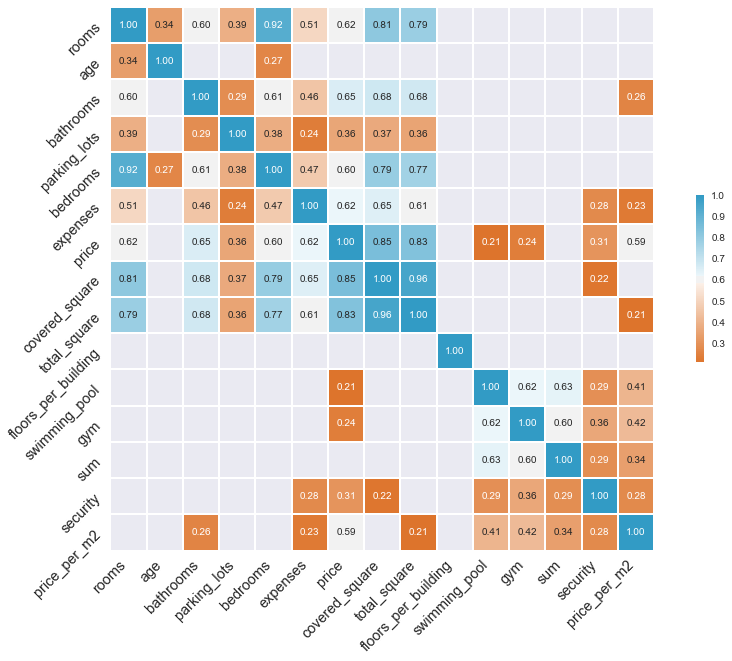

In [37]:
corr = data.corr()

# figure
fig, ax = plt.subplots(figsize=(15,10))

# color map
cmap = sns.diverging_palette(30, 230, 90, 60, as_cmap=True)

# plt heatmap
g = sns.heatmap(corr, 
                cmap=cmap, 
                annot=True, 
                fmt=".2f", 
                linewidths=1,
                square=True, 
                cbar_kws={'fraction' : 0.01},
                mask = corr < 0.2)

g.set_xticklabels(g.get_xticklabels(),
                  rotation=45, 
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-large'
                 )
g.set_yticklabels(g.get_yticklabels(), 
                  rotation=45, 
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-large')

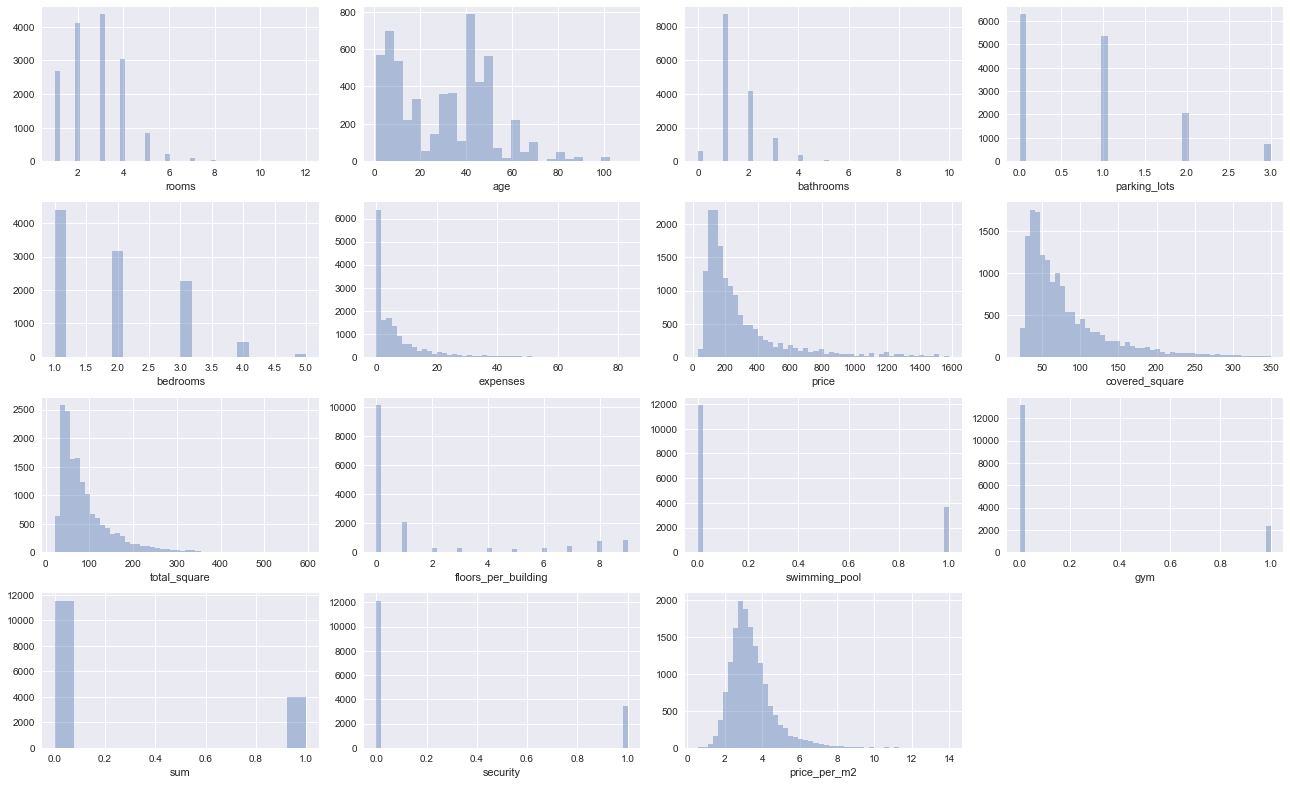

In [38]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(data.drop('district', axis=1).dropna()):
    plt.subplot(6,4,index+1)
    sns.distplot(data.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

In [39]:
fig = px.strip(data, x='district', y='price_per_m2', color='district')
fig.show()

In [40]:
fig = px.box(data, x = 'district', y="price_per_m2", color='district')
fig.show()

In [41]:
prices = data.groupby('district')['price_per_m2'].mean().to_frame()
barrios = gpd.read_file('barrios.geojson')

prices = prices.reset_index()
prices.columns = ['name', 'price']

In [42]:
def replacer(word):
    
    word = word.replace('í', 'i')
    word = word.replace('ó', 'o')
    word = word.replace('ú', 'u')
    word = word.replace('é', 'e')
    
    return word

In [43]:
prices.name = prices.name.apply(lambda x: replacer(x))
barrios.name = barrios.name.apply(lambda x: replacer(x))

In [48]:
m = folium.Map([-34.6083, -58.3712], zoom_start=12)

folium.Choropleth(
    geo_data=barrios,
    data=prices,
    columns=['name', 'price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color='purple',
    nan_fill_opacity=0.4,
    legend_name='Average price per meter (1000$)',
    highlight=True,
).add_to(m)

folium.map.CustomPane("labels").add_to(m)

folium.TileLayer("CartoDBPositronOnlyLabels", pane="labels").add_to(m)

In [49]:
display(m)

In [46]:
import statsmodels.api as sm

df = data.dropna().copy()

df['log(price)'] = df.price.apply(lambda x: np.log(x))

df = df.reset_index(drop=True)
df = pd.get_dummies(df)
df.shape

(4893, 62)

In [47]:
y = df['log(price)']
X = df.drop(['log(price)', 'price', 'price_per_m2'], axis=1)

X = sm.add_constant(X)

model = sm.OLS(y,X).fit()

summary = model.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:             log(price)   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     621.9
Date:                Sun, 30 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:38:49   Log-Likelihood:                 161.38
No. Observations:                4893   AIC:                            -204.8
Df Residuals:                    4834   BIC:                             178.5
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         